# 인물사진

In [3]:
!pip install opencv-python pixellib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 51.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 56.9 MB/s eta 0:00:00:00:0100:01
  DEPRECATION: Building 'fvcore' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` o

In [4]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.11.0


## 1. 아웃포커싱 사람 사진

### Step 1. 사진 준비

원본 사람 이미지 크기: (799, 1200, 3)


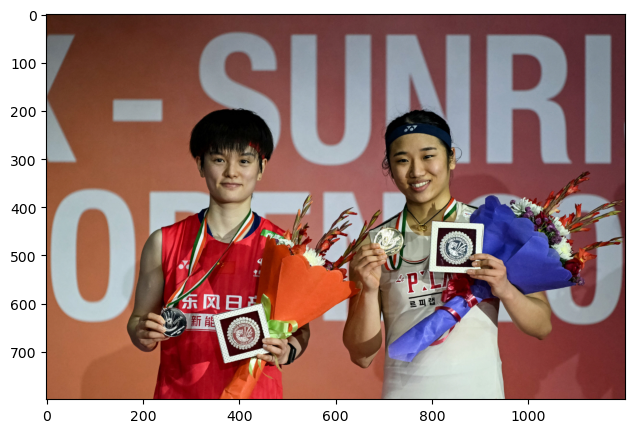

In [5]:
person_img_path = "images/person.jpg"
person_img = cv2.imread(person_img_path)

person_img = cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)

print(f"원본 사람 이미지 크기: {person_img.shape}")

plt.figure(figsize=(10, 5))
plt.imshow(person_img)
plt.show()

In [12]:
min_size = min(person_img.shape[0], person_img.shape[1])
min_size

799

### Step 2. 세그멘테이션으로 사람 분리하기

In [52]:
model = deeplabv3_resnet101(pretrained=True).eval() ## 모델 준비

'''
# 기존코드
transform = T.Compose([  ## 사전 학습 모델과 동일하게 입력크기를 맞춰줌
    T.ToPILImage(),
    T.Resize((520, 520)),  ### 모델 입력 크기 (고정)
    T.ToTensor(),
])
'''
# normalize 추가한 코드 ===============
transform = T.Compose([
    T.ToPILImage(),
    T.Resize(min_size), # 비율유지
    T.ToTensor(),
    T.Normalize(                   # ImageNet 학습 데이터 전체의 RGB 채널별 픽셀 평균과 표준편차로 정규화
        mean=[0.485, 0.456, 0.406],  #값은 링크 참조 (https://docs.pytorch.org/vision/0.8/models.html)
        std=[0.229, 0.224, 0.225]
    )
])
# ====================================
#'''
input_tensor = transform(cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)).unsqueeze(0) ## 전처리 코드

In [53]:
%%time

## 추론 코드
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions,
                                        (person_img.shape[1], person_img.shape[0]),
                                        interpolation=cv2.INTER_NEAREST)

CPU times: user 33.3 s, sys: 3.35 s, total: 36.7 s
Wall time: 37.1 s


In [54]:
## pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

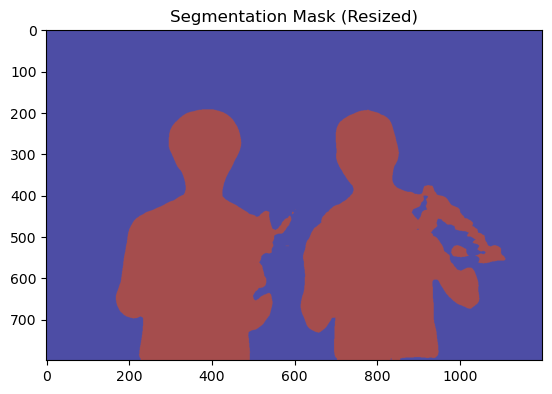

0 background
15 person


In [55]:
## 사람만 출력

plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

### 클래스 번호 매칭
unique_classes = np.unique(output_predictions_resized)

for class_id in unique_classes:
    print(class_id, LABEL_NAMES[class_id])

In [56]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

#print(colormap[:20])  # 생성한 20개의 컬러맵 출력
print(colormap[12]) #컬러맵 12에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 [강아지])

[ 64   0 128]


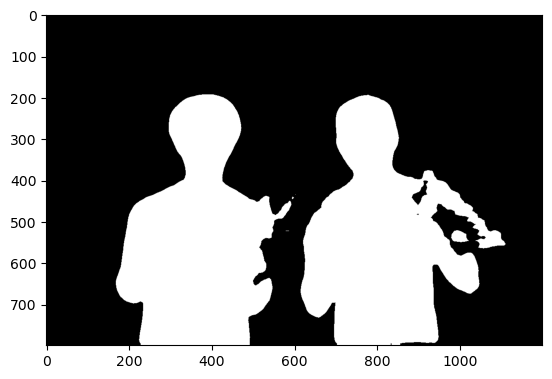

In [57]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

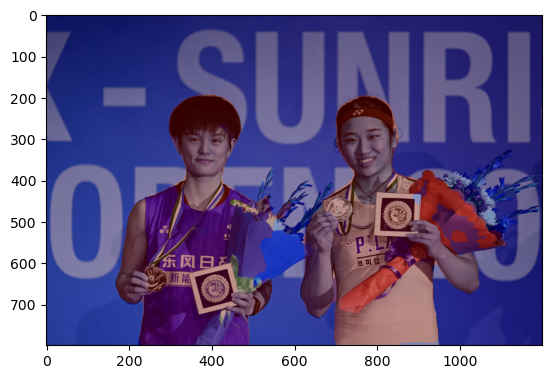

In [58]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(person_img, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### Step 3. 배경 흐리게 하기

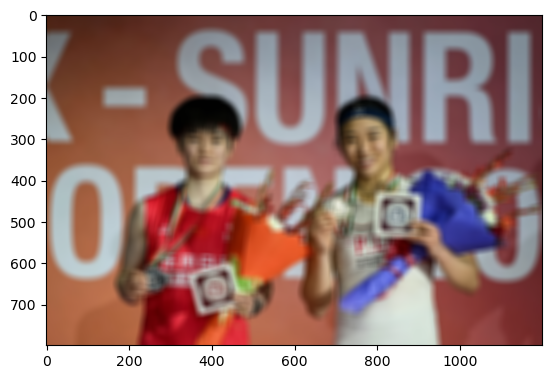

In [59]:
# 이미지 흐리게 하기
person_img_blur = cv2.blur(person_img, (20, 20)) # (13,13)은 blurring kernel size를 뜻합니다
plt.imshow(person_img_blur)
plt.show()

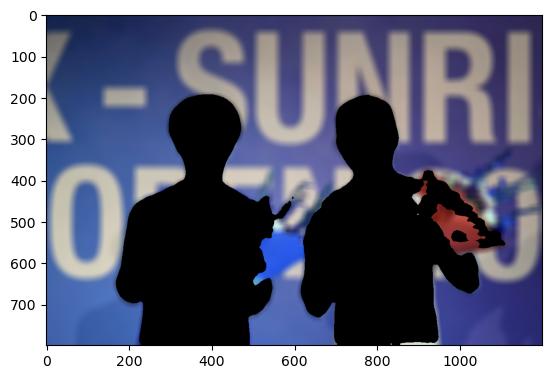

In [60]:
#흐려진 이미지에서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(person_img_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

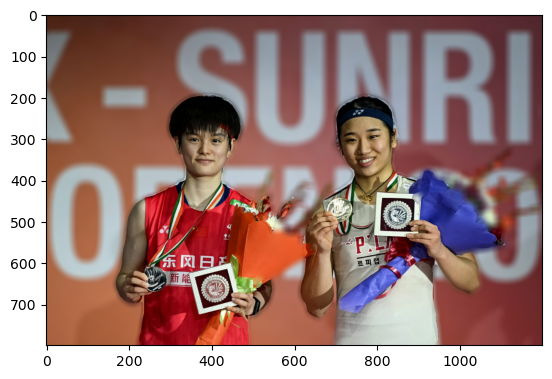

In [61]:
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, person_img, img_bg_blur)
plt.imshow(img_concat)
plt.show()


### Step 4. 문제점 찾고 해결하기

- 사람의 머리의 일부를 배경으로 인식함  
<img src="images/problem02.jpg" width="900px" height="300px"></img>

- 제안: 입력 분포를 ImageNet 학습 분포와 일치시키기 위해 transform에 normalize 추가하여 인식률 높이기
<img src="images/solution02.jpg" width="900px" height="300px"></img>

## 2. 아웃포커싱 동물 사진

### Step 1. 사진 준비

원본 강아지 이미지 크기: (313, 500, 3)


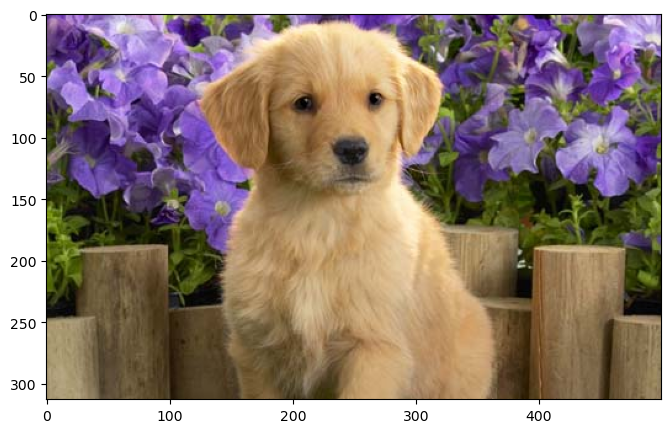

In [150]:
dog_img_path = "images/dog.jpg"
dog_img = cv2.imread(dog_img_path)

dog_img = cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB)

print(f"원본 강아지 이미지 크기: {dog_img.shape}")

plt.figure(figsize=(10, 5))
plt.imshow(dog_img)
plt.show()

### Step 2. 세그멘테이션으로 강아지 분리하기

In [160]:
model = deeplabv3_resnet101(pretrained=True).eval() ## 모델 준비

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
    #T.Normalize(                   # ImageNet 학습 데이터 전체의 RGB 채널별 픽셀 평균과 표준편차로 정규화
    #    mean=[0.485, 0.456, 0.406],  #값은 링크 참조 (https://docs.pytorch.org/vision/0.8/models.html)
    #    std=[0.229, 0.224, 0.225]
    #)
])
input_tensor = transform(cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB)).unsqueeze(0) ## 전처리 코드

In [161]:
%%time

## 이미지 입력
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (dog_img.shape[1], dog_img.shape[0]), interpolation=cv2.INTER_NEAREST)

CPU times: user 9.35 s, sys: 228 ms, total: 9.58 s
Wall time: 9.67 s


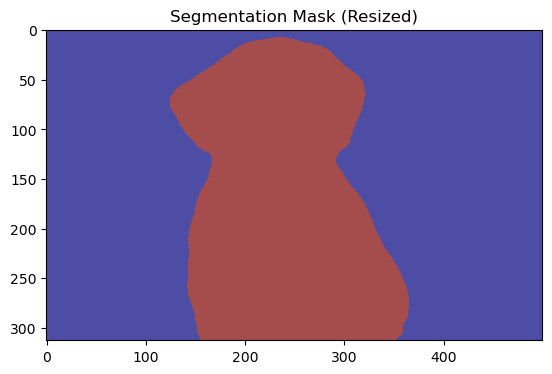

0 background
12 dog


In [162]:
## 강아지만 출력

plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

### 클래스 번호 매칭
unique_classes = np.unique(output_predictions_resized)

for class_id in unique_classes:
    print(class_id, LABEL_NAMES[class_id])

In [163]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

#print(colormap[:20])  # 생성한 20개의 컬러맵 출력
print(colormap[12]) #컬러맵 12에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 [강아지])

[ 64   0 128]


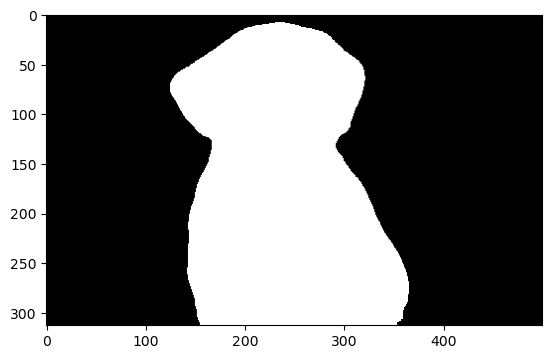

In [164]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 12)  # 클래스 ID 12 (강아지)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

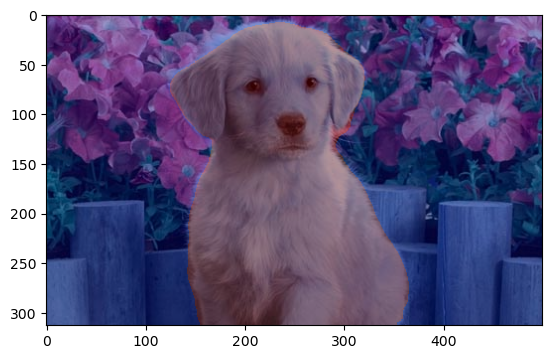

In [165]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(dog_img, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### Step 3. 배경 흐리게 하기

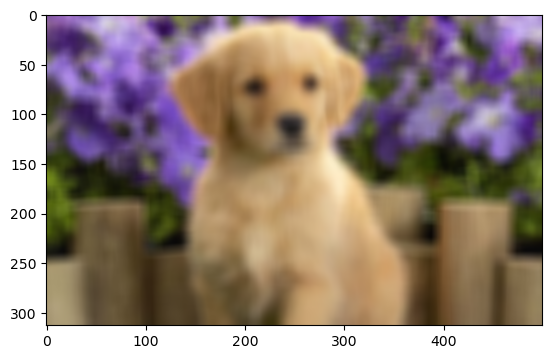

In [166]:
# 이미지 흐리게 하기

dog_img_blur = cv2.blur(dog_img, (13, 13)) # (13,13)은 blurring kernel size를 뜻합니다
plt.imshow(dog_img_blur)
plt.show()

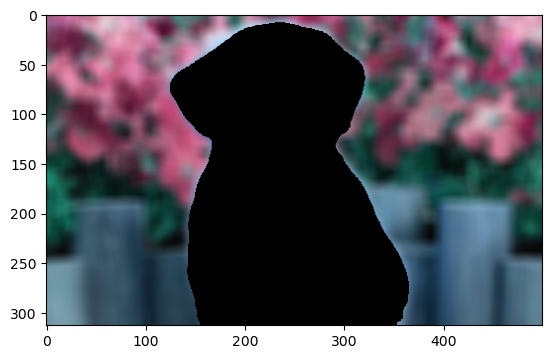

In [167]:
#흐려진 이미지에서 배경만 추출하기

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 객체가 255 였으나
# 연산을 하고 나면 배경은 255 객체는 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(dog_img_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### Step 4. 흐린 배경과 원본 영상 합성

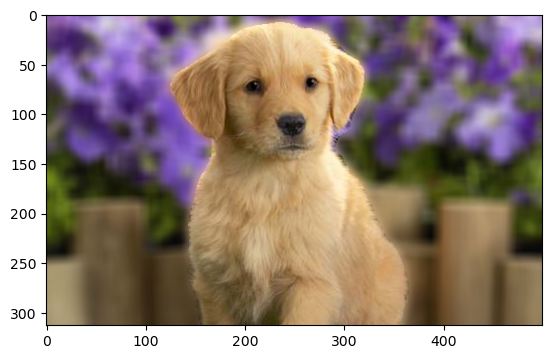

In [168]:
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, dog_img, img_bg_blur)
plt.imshow(img_concat)
plt.show()


## 3. 배경전환 크로마키 사진

### Step 1. 인물모드 직접 해보기

원본 고양이 이미지 크기: (630, 1200, 3)
배경(사막) 이미지 크기: (403, 799, 3)


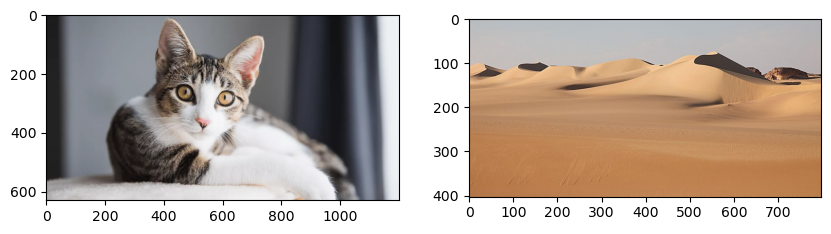

In [169]:
cat_img_path = "images/cat.jpg"  # 고양이 이미지를 준비해주세요
sand_img_path = "images/sand.png"  # 사막 배경 이미지를 준비해주세요

cat_img = cv2.imread(cat_img_path)
sand_img = cv2.imread(sand_img_path)

cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [170]:
model = deeplabv3_resnet101(pretrained=True).eval()

'''
# 기존코드
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])
'''

# normalize 추가한 코드 ===============
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
    T.Normalize(                   # ImageNet 학습 데이터 전체의 RGB 채널별 픽셀 평균과 표준편차로 정규화
        mean=[0.485, 0.456, 0.406],  #값은 링크 참조 (https://docs.pytorch.org/vision/0.8/models.html)
        std=[0.229, 0.224, 0.225]
    )
])
# ====================================

input_tensor = transform(cat_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    print(output.shape)
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

torch.Size([21, 520, 520])
추론 마스크 크기 (Before Resize): (520, 520)


In [171]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (630, 1200)


In [172]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [0 8]


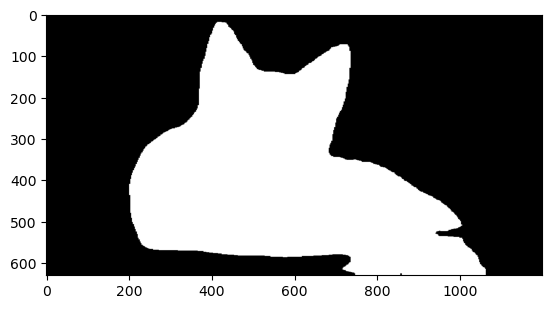

In [173]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

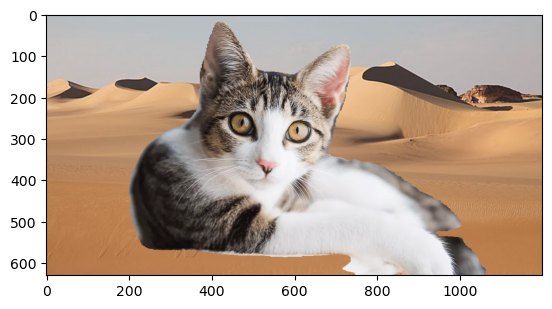

In [174]:
# 배경을 고양이 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 고양이 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

### Step 2. 사진에서 문제점 찾기

<img src="images/problem01.jpg" width="450px" height="300px"></img>

### Step 3. 해결 방법을 제안해보기

- 소파의 색상과 질감이 고양이 털과 비슷해서 고양이 클래스와 같은 semantic mask 영역으로 포함됨
- 제안: 입력 분포를 ImageNet 학습 분포와 일치시키기 위해 transform에 normalize 추가하여 인식률 높이기

In [175]:
'''
# 기존코드
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])
'''

# normalize 추가한 코드 ===============
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# ====================================

<img src="images/solution01.png" width="450px" height="300px"></img>

# 추가 TEST

원본 사람 이미지 크기: (900, 720, 3)


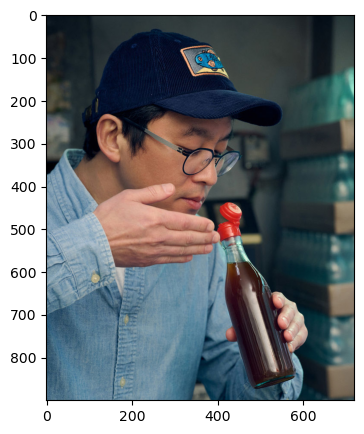

In [97]:
person_img_path = "images/person_2.jpg"
person_img = cv2.imread(person_img_path)

person_img = cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)

print(f"원본 사람 이미지 크기: {person_img.shape}")

plt.figure(figsize=(10, 5))
plt.imshow(person_img)
plt.show()

In [98]:
min_size = min(person_img.shape[0], person_img.shape[1])
min_size

720

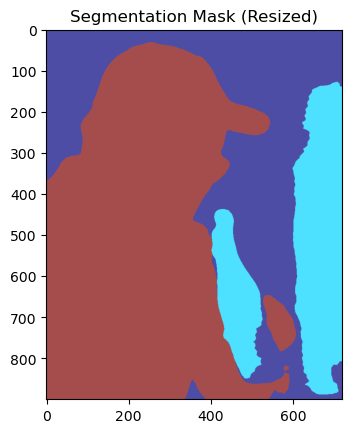

0 background
5 bottle
15 person


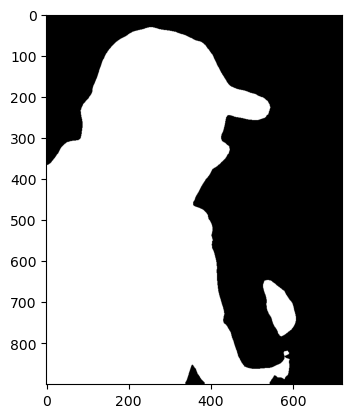

In [99]:
model = deeplabv3_resnet101(pretrained=True).eval() ## 모델 준비

transform = T.Compose([
    T.ToPILImage(),
    T.Resize(min_size), # 비율유지
    T.ToTensor(),
    T.Normalize(                   # ImageNet 학습 데이터 전체의 RGB 채널별 픽셀 평균과 표준편차로 정규화
        mean=[0.485, 0.456, 0.406],  #값은 링크 참조 (https://docs.pytorch.org/vision/0.8/models.html)
        std=[0.229, 0.224, 0.225]
    )
])

input_tensor = transform(cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)).unsqueeze(0) ## 전처리 코드

## 추론 코드
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions,
                                        (person_img.shape[1], person_img.shape[0]),
                                        interpolation=cv2.INTER_NEAREST)

## 사람만 출력
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

### 클래스 번호 매칭
unique_classes = np.unique(output_predictions_resized)

for class_id in unique_classes:
    print(class_id, LABEL_NAMES[class_id])

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()


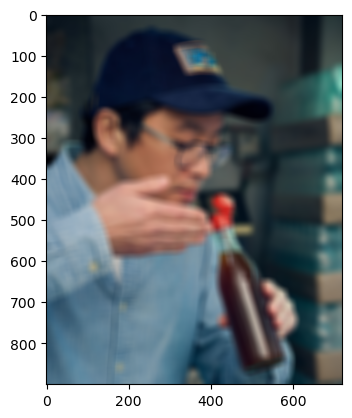

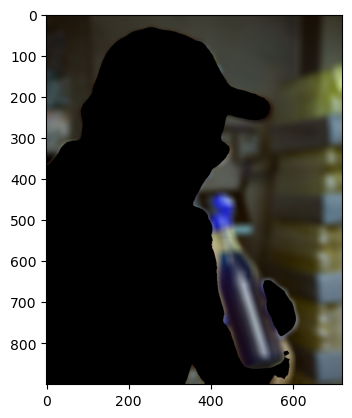

In [101]:
# 이미지 흐리게 하기
person_img_blur = cv2.blur(person_img, (20, 20)) # (13,13)은 blurring kernel size를 뜻합니다
plt.imshow(person_img_blur)
plt.show()

#흐려진 이미지에서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(person_img_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

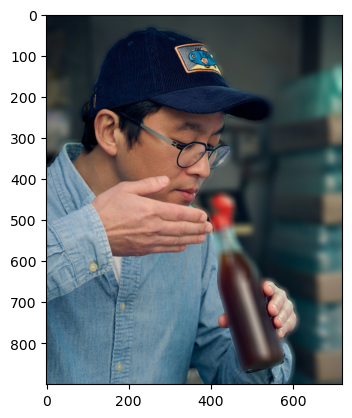

In [90]:
# np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, person_img, img_bg_blur)
plt.imshow(img_concat)
plt.show()


- 문제점: 손에 들고있는 참기름도 블러처리됨  
- 해결책: 사람 몸에 닿아있는 것은 선명하게 후처리로 복구함